In [1]:
import Yukawa_SINDy as ys
import Yukawa3body as y3
import numpy as np
import pysindy as ps

# Noise analysis for 3-body Yukawa system

Here, we load in the data used for all the noise cases used in this notebook. The data is a list of 200 `y3.Yukawa3body` objects with *no noise added*, and the data is *unsubtracted*.

In [10]:
# load in data
sim_list = y3.load_data('data/basic_noisy/analysis_trajectories')

We can extract the simulation parameters used in this set by taking a look at the object attributes from the first element.

In [15]:
# print simulation parameters
print("Number of trajectories:", len(sim_list))
print("Timestep duration:", sim_list[0].dt)
print("Duration:", sim_list[0].duration)
print("Number of timesteps (sanity check):", sim_list[0].x.shape[0])
print("Number of features (sanity check):", sim_list[0].x.shape[1])
print("Noisy:", sim_list[0].is_noisy)
print("Subtracted:", sim_list[0].is_subtracted)

Number of trajectories: 200
Timestep duration: 0.0001
Duration: 0.1
Number of timesteps (sanity check): 1001
Number of features (sanity check): 12
Noisy: False
Subtracted: False


Below is some code that will generate plots of 9 of the trajectories *with noise added*. 

In [ ]:
for sim in sim_list:
    if sim.is_noisy:
        sim.delete_noise()
    sim.add_gaussian_noise(noise_level=1e-4)

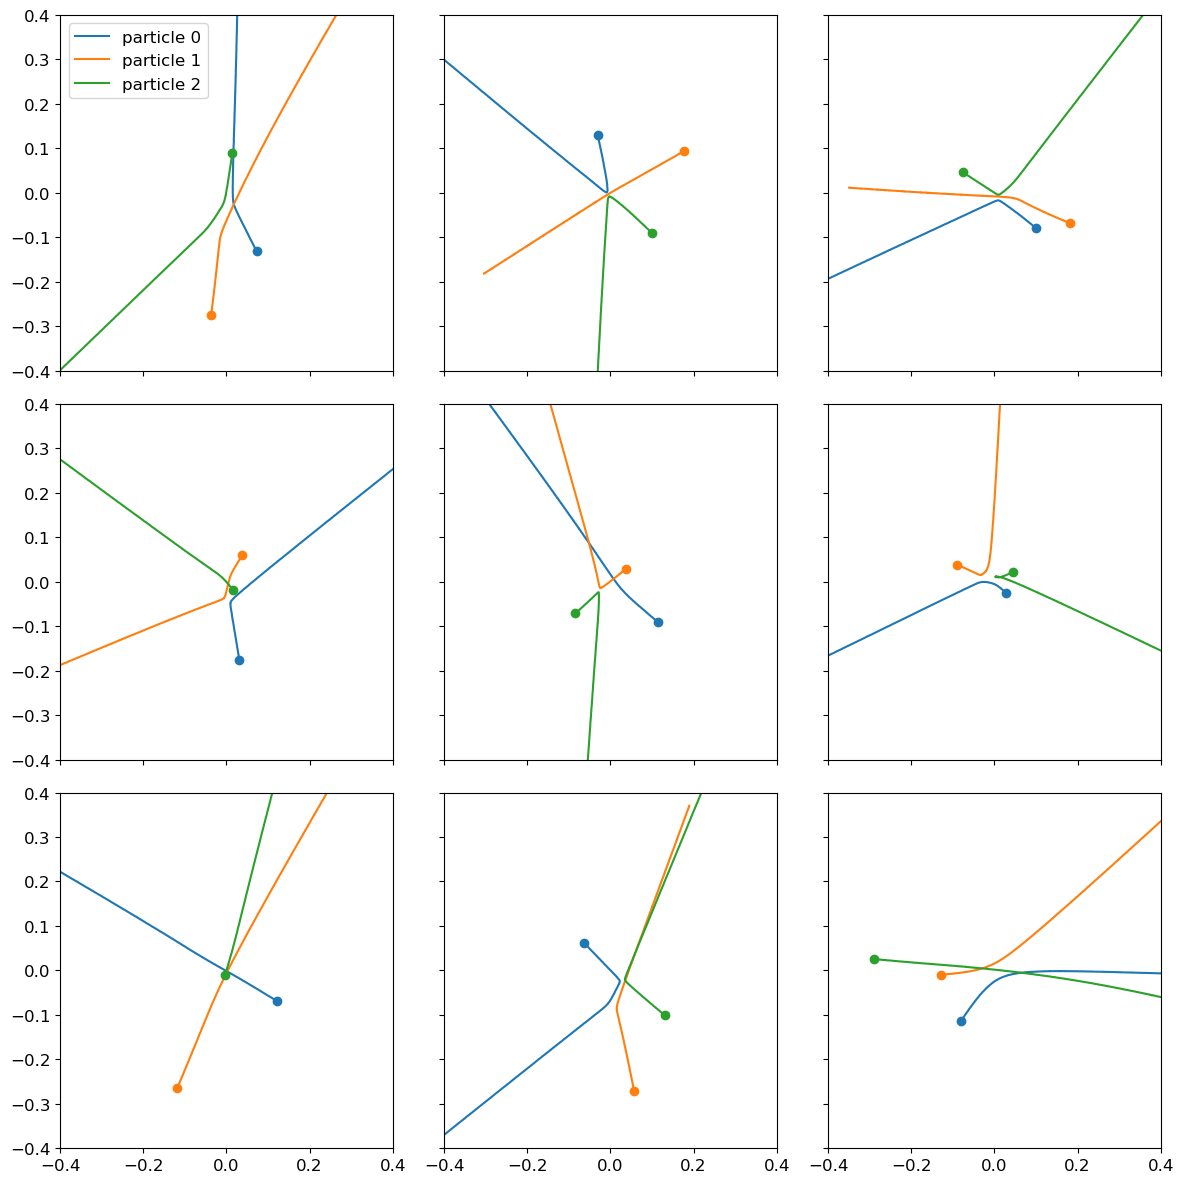

In [ ]:
y3.plot_multiple(sim_list[190:])

## `noise_level = 0`

We begin by looking at the clean data, with no Gaussian noise added. SINDy models were generated using the python script 'Code/data/basic_sindy_results_noisy.py'.

In [16]:
# load in SINDy models for 0 noise case
nonoise_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00000/model_objs')
# remove models with threshold > 1 from list
nonoise_models = [model for model in nonoise_models if model.optimizer.threshold <= 1]

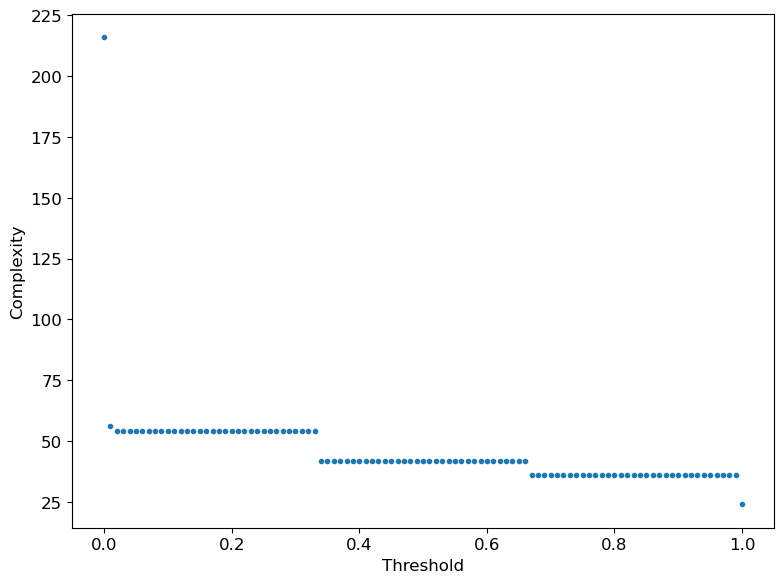

In [17]:
ys.plot_complexity_objs(nonoise_models)

- course-graining (threshold scan from 0 to 0.45, increment 0.05) shows that the correct model is discovered some point between 0.3 and 0.35.
- I want to find the transition point from bad to good model to 3 significant figures, so I then did a more fine step of 0.005 and found that the discovered model becomes correct between 0.330 and 0.335
- Finally, investigating  between 0.328 and 0.337 by steps of 0.001 we find the critical threshold to be 0.334.
- This is not reflected in the plot above, which was made later.

Below are the models for `threshold=0.330` and `threshold=0.340`. We can see that in the 0.330 case, all of the trivial equations (of the form $\dot{x}=v$) are characterized by extremely large coefficients ($\sim 10^6$) for all the velocity features available to them *that are in the correct cartesian direction*. For example, the `(y0-y1)'`-equation has all 6 velocity features (of the form `(vxi-vxj)` and `(vyi-vyj)` for $i,j\in\{0,1,2|i\neq j\}$). On the other hand, the interesting equations (of the form $\dot{v}=f(x)$) are "correctly" discovered.

In [ ]:
for i in [33,34]:
    y3.print_SINDy_nice(nonoise_models[i], sim_list)

noise level: 0.0001
number of trajectories: 200
STLSQ threshold: 0.33
complexity: 54
(x0-x1)'      = 738059.737 vx0-vx1
              + 738058.737 vx1-vx2
              + 738058.737 vx2-vx0

(vx0-vx1)'    = 2.180 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 1.993 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)
              + -1.073 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -0.997 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)^(3/2)
              + -1.058 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)
              + -0.997 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)^(3/2)

(y0-y1)'      = -4075106.869 vy0-vy1
              + -4075107.869 vy1-vy2
              + -4075107.869 vy2-vy0

(vy0-vy1)'    = 2.173 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 1.993 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)

## `noise_level = 1e-5`

In [ ]:
noise00001_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00001/model_objs')

- The approximately correct model is discovered with a threshold of 0.40, where we only stepped the solver with 0.01 resolution.
- The complexity vs. threshold plot is shown here:

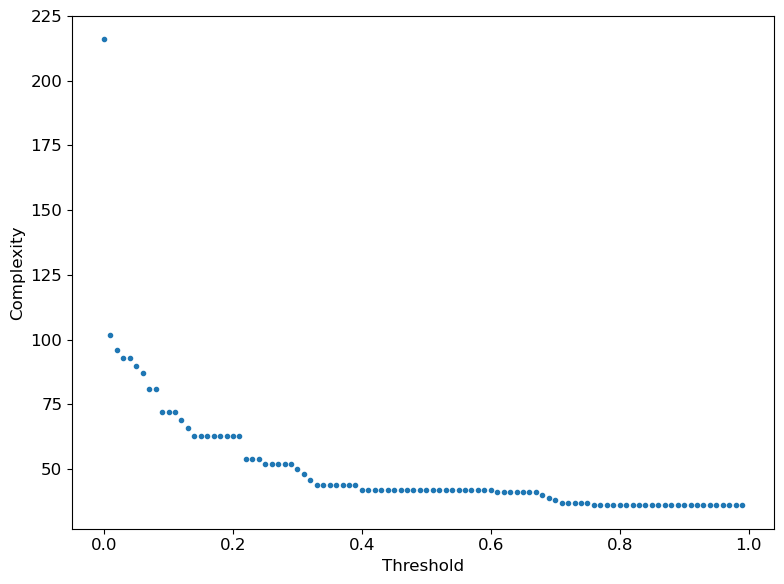

In [24]:
ys.plot_complexity_objs(noise00001_models)

We can look at the models around 0.4 to see how they evolve to the correct model.

In [39]:
for i in [39,40]:
    y3.print_SINDy_nice(noise00001_models[i], sim_list)

noise level: 0.0001
number of trajectories: 200
STLSQ threshold: 0.39
complexity: 44
(x0-x1)'      = 1.000 vx0-vx1

(vx0-vx1)'    = 2.193 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 1.993 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)
              + -1.071 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -0.997 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)^(3/2)
              + -1.050 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)
              + -0.997 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)^(3/2)

(y0-y1)'      = 1.000 vy0-vy1

(vy0-vy1)'    = 2.167 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 1.993 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)
              + -1.082 (y1-y2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -0.996 (y1-y2) 

- As we can see above, the only equation that is wrong with `threshold=0.39` is the `(y1-y2)'` equation, which proves to be an issue later as well (see below).
- It could be interesting to investigate whether that is a problem with this particular set of trajectories. There is no obvious reason why that particular equation would be an issue.

## `noise_level = 2e-5`

In [21]:
noise00002_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00002/model_objs')
noise00002_models = [model for model in noise00002_models if model.optimizer.threshold <= 1]

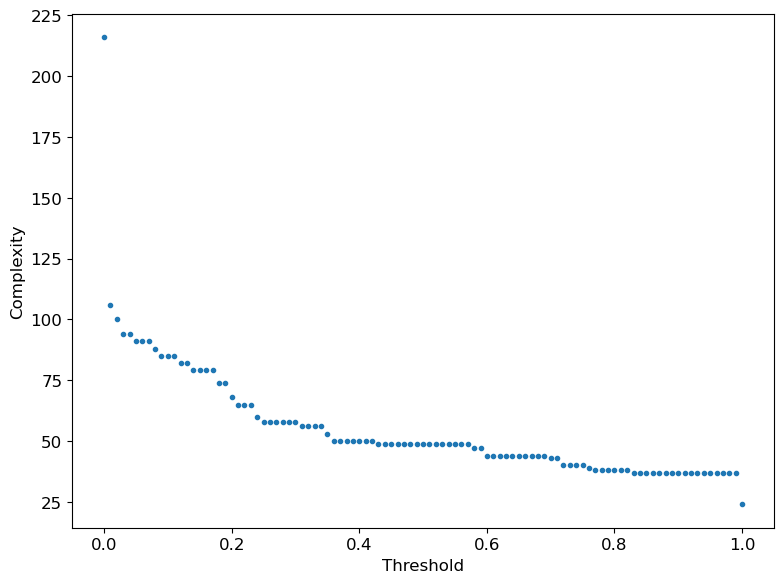

In [22]:
ys.plot_complexity_objs(noise00002_models)

- Interestingly, the steps here are much more small and incremental than in the no noise case
- Here, the correct model is *not* discovered. We can check around the correct complexity value and see how close we get.
- The model generated with threshold=0.64 comes the closest to the true model without zeroing out any coefficients shown below

In [51]:
for i in [57,58,60]:
    y3.print_SINDy_nice(noise00002_models[i], sim_list)

noise level: 0.0001
number of trajectories: 200
STLSQ threshold: 0.5700000000000001
complexity: 49
(x0-x1)'      = 1.000 vx0-vx1

(vx0-vx1)'    = 2.207 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 1.992 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)
              + -1.070 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -0.997 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)^(3/2)
              + -1.042 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)
              + -0.998 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)^(3/2)

(y0-y1)'      = 1.000 vy0-vy1

(vy0-vy1)'    = 2.161 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 1.994 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)
              + -1.085 (y1-y2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -

- In all three cases shown here, we can see that the `(vx1-vx2)'` equation contains extraneous terms with very large coefficients
- In the first case with `threshold=0.57` we can see that there are no equations in which all the coefficients are zero. Problematic equations are only the `(vx1-vx2)'` equation, the `(y1-y2)'` equation, and the `(vy2-vy0)` equation which contain extraneous terms.
- At `threshold=0.58`, we can see that instead of settling into the correct form, thresholding forces the `(y1-y2)'`-equation to be zero, while the extraneous terms remain in the `(vx1-vx2)'` and `(vy2-vy0)` equations.
- In the third case, `threshold=0.60`, we can see that the extraneous terms in the `(vy2-vy0)'` equation go to zero.

## `noise_level = 3e-5`

In [ ]:
noise00003_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00003/model_objs')
noise00003_models = [model for model in noise00002_models if model.optimizer.threshold <= 1]

## `noise_level = 4e-5`

In [25]:
noise00004_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00004/model_objs')
noise00004_models = [model for model in noise00002_models if model.optimizer.threshold <= 1]

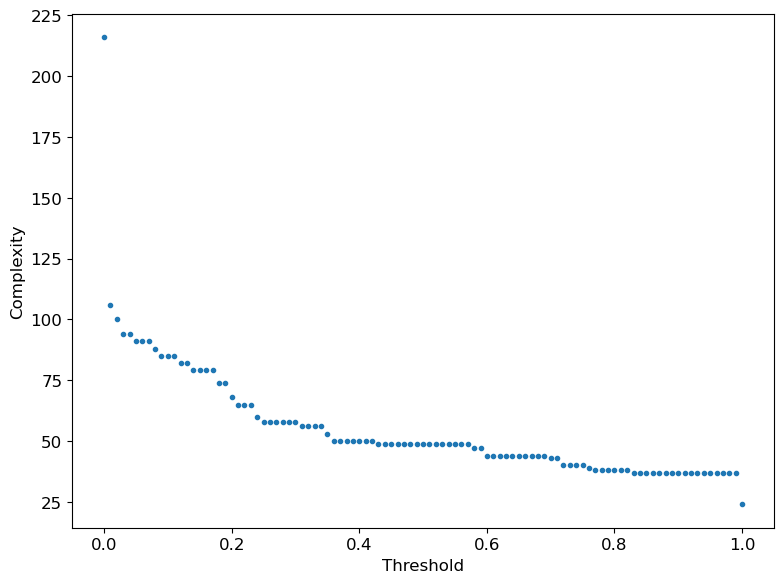

In [26]:
ys.plot_complexity_objs(noise00004_models)

In [37]:
y3.print_SINDy_nice(noise00004_models[72], sim_list)

noise level: 0.0001
number of trajectories: 200
STLSQ threshold: 0.72
complexity: 40
(x0-x1)'      = 1.000 vx0-vx1

(vx0-vx1)'    = 2.207 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 1.992 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)
              + -1.070 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -0.997 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)^(3/2)
              + -1.042 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)
              + -0.998 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)^(3/2)

(y0-y1)'      = 1.000 vy0-vy1

(vy0-vy1)'    = 2.161 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 1.994 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)
              + -1.085 (y1-y2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -0.996 (y1-y2) 